In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [5]:
data = pd.read_csv('../data/phishing_email.csv')

In [6]:
# Split into train and test sets
X = data["text_combined"]
Y = data["label"]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.2,
    stratify=Y,
    random_state=42
)

print("Training data shape: ", X_train.shape)
print("Testing data shape: ", X_test.shape)

Training data shape:  (65988,)
Testing data shape:  (16498,)


In [7]:
# Instantiate the TF-IDF vectorizer
tfidf = TfidfVectorizer(
    ngram_range=(3, 5),
    analyzer="char",
    min_df=5,
    max_df=0.9,
    sublinear_tf=True
)

In [8]:
# Instantiate the Logistic Regression model
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    solver="liblinear",
    random_state=42
)

In [9]:
# Create a pipeline that first transforms the data using TF-IDF and then 
# fits the Logistic Regression model
pipeline = Pipeline([
    ("tfidf", tfidf),
    ("clf", log_reg)
])

pipeline.fit(X_train, Y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [10]:
# apply to test data
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

In [11]:
print(y_pred)
print(y_proba)

[1 0 1 ... 1 0 0]
[0.92507425 0.02663194 0.72915924 ... 0.92363815 0.01358599 0.00633082]


In [12]:
# get metric report
print(classification_report(Y_test, y_pred, digits=4))
print("ROC-AUC:", roc_auc_score(Y_test, y_proba)) 

              precision    recall  f1-score   support

           0     0.9898    0.9847    0.9873      7919
           1     0.9860    0.9907    0.9883      8579

    accuracy                         0.9878     16498
   macro avg     0.9879    0.9877    0.9878     16498
weighted avg     0.9878    0.9878    0.9878     16498

ROC-AUC: 0.9991328155141621


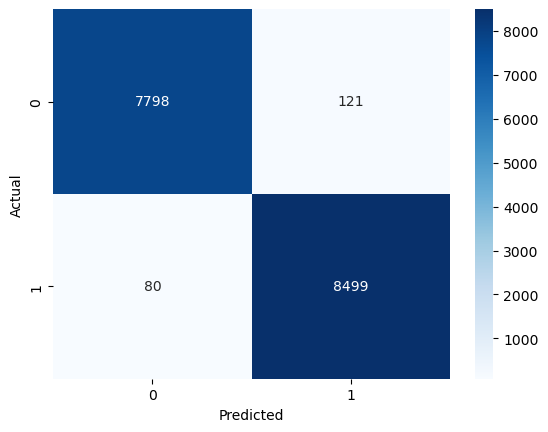

In [13]:
# plot confusion matrix
cm = confusion_matrix(Y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [14]:
# Inspecting important n-grams
feature_names = pipeline.named_steps["tfidf"].get_feature_names_out()
coefs = pipeline.named_steps["clf"].coef_[0]

top_spam = sorted(
    zip(feature_names, coefs),
    key=lambda x: x[1],
    reverse=True
)[:20]

top_legit = sorted(
    zip(feature_names, coefs),
    key=lambda x: x[1])[:20]

print("Top 20 n-grams indicative of spam:")
for feature, coef in top_spam:
    print(f"{feature}: {coef:.4f}")

print("\nTop 20 n-grams indicative of legitimate emails:")
for feature, coef in top_legit:
    print(f"{feature}: {coef:.4f}")

Top 20 n-grams indicative of spam:
com : 3.8912
om : 3.4319
ttp : 2.5495
http : 2.5465
 201: 2.5301
com: 2.3799
 com : 2.3260
med: 2.3065
fe : 2.2778
tp : 2.2268
 cli: 2.1843
ove: 2.1446
men : 2.1373
201: 2.1301
 med: 2.1246
lick : 2.1217
 clic: 2.0068
 life: 2.0039
ife: 1.9979
 lif: 1.9962

Top 20 n-grams indicative of legitimate emails:
enron: -3.8662
nron: -3.8581
enro: -3.8285
enr: -3.7449
nro: -3.7298
 enro: -3.6686
nron : -3.6571
 enr: -3.5725
wrot: -3.5321
wrote: -3.5245
 wrot: -3.5192
rote : -3.5076
 wro: -3.3513
wro: -3.2961
 wr: -2.8869
ote : -2.8840
ron : -2.7615
rote: -2.7306
___: -2.7101
____: -2.6821


In [16]:
# save model
joblib.dump(pipeline, "../models/logreg_phishing_model.joblib")

['../models/logreg_phishing_model.joblib']